In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from scipy.optimize import curve_fit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# I. Data Loading

In [27]:
# Loading the Monthly Solar Data
file_path = 'solar_data.xlsx'
sheet_name = 'solarbymonth'

# Read the Excel sheet into a Pandas DataFrame
monthly_data = pd.read_excel(file_path, sheet_name=sheet_name)

# Extract relevant columns
monthly_data['Month'] = pd.to_datetime(monthly_data['Month'])  # Ensure the 'Month' column is in datetime format
months = monthly_data['Month']
utility_gen = monthly_data['Utility Scale Generation']
small_scale_gen = monthly_data['Small Scale Generation']
total_solar = monthly_data['Total Solar']

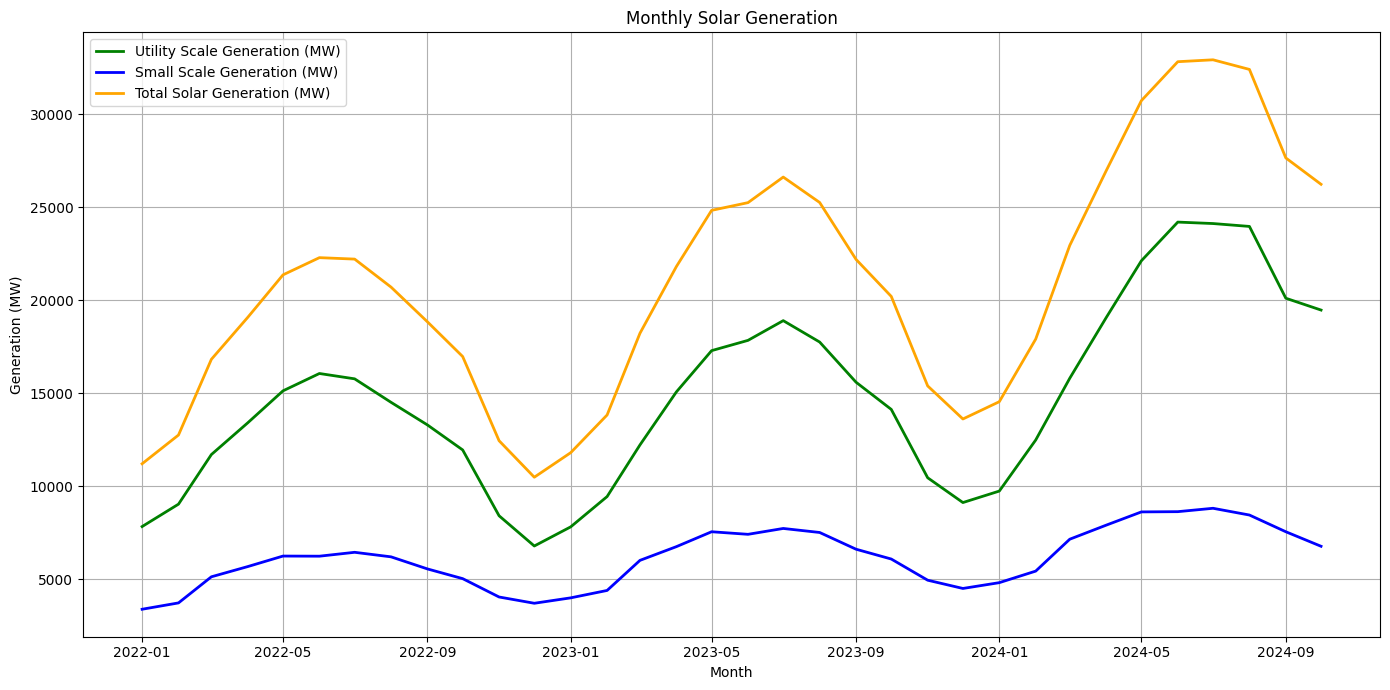

In [28]:
# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(months, utility_gen, label='Utility Scale Generation (MW)', color='green', linewidth=2)
plt.plot(months, small_scale_gen, label='Small Scale Generation (MW)', color='blue', linewidth=2)
plt.plot(months, total_solar, label='Total Solar Generation (MW)', color='orange', linewidth=2)
plt.xlabel('Month')
plt.ylabel('Generation (MW)')
plt.title('Monthly Solar Generation')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [29]:
# Loading the TSI Data
data_dir = 'tsi_monthly'

# Find all NetCDF files in the directory
file_paths = sorted(glob(os.path.join(data_dir, 'tsi_*.nc')))

# Initialize an empty list to store DataFrames
data_frames = []

# Loop through each file and load the data
for file_path in file_paths:
    # Open the NetCDF file
    dataset = xr.open_dataset(file_path)
    
    # Convert the dataset to a Pandas DataFrame and reset the index
    df = dataset.to_dataframe().reset_index()
    
    # Ensure the 'time' column is in datetime format
    df['time'] = pd.to_datetime(df['time'])
    
    # Append the DataFrame to the list
    data_frames.append(df)

all_data = pd.concat(data_frames, ignore_index=True)

# Verify loading
print(all_data.head())

        time  bounds          TSI   TSI_UNC  time_bnds
0 2014-01-15       0  1361.692383  0.152830 2014-01-01
1 2014-01-15       1  1361.692383  0.152830 2014-02-01
2 2014-02-15       0  1361.590088  0.173391 2014-02-01
3 2014-02-15       1  1361.590088  0.173391 2014-03-01
4 2014-03-15       0  1362.293213  0.133309 2014-03-01


In [12]:
# Loading the Exponential Regression Data

def exp_func(x, a, b):
    return a * np.exp(b * x)

file_path = 'solar_data.xlsx'
sheet_name = 'capacitygrowth'

# Read the Excel sheet into a Pandas DataFrame
solar_data = pd.read_excel(file_path, sheet_name=sheet_name)

# Sum the residential and commercial annual capacities into small scale
solar_data['Small Scale Annual'] = solar_data['Residential Annual'] + solar_data['Commercial Annual']
solar_data['Small Scale Cumul'] = solar_data['Residential Cumul'] + solar_data['Commercial Cumul']

# Extract relevant columns
years = solar_data['Year']
small_scale_annual = solar_data['Small Scale Annual']
utility_annual = solar_data['Utility Annual']
small_scale_cumul = solar_data['Small Scale Cumul']
utility_cumul = solar_data['Utility Cumul']

# Normalize the years to start from 0 for better numerical stability
normalized_years = years - years.min()

# Perform regression for small scale
params_small, _ = curve_fit(exp_func, normalized_years, small_scale_cumul, maxfev=10000)
small_scale_pred = exp_func(normalized_years, *params_small)

# Perform regression for utility
params_utility, _ = curve_fit(exp_func, normalized_years, utility_cumul, maxfev=10000)
utility_pred = exp_func(normalized_years, *params_utility)

# Verify loading
print(params_small)
print(params_utility)

[2.38570266e+03 2.05533322e-01]
[3.00547527e+03 2.30188812e-01]


# II. SARIMAX Analysis

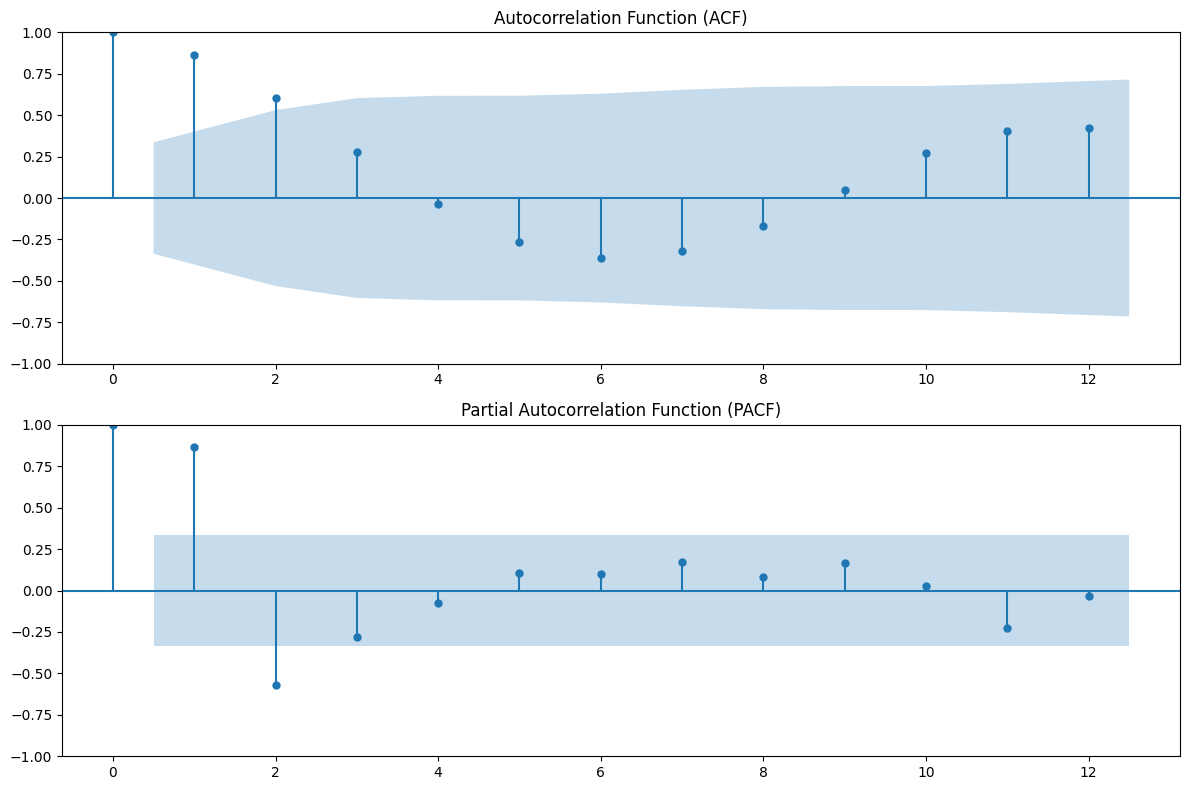

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(total_solar, lags=12, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(total_solar, lags=12, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

#### Interpreting ACF and PACF:
Here we can see that the first lag in the PACF is significantly out of limit and the second one  is also out of the significant limit, but it is not that far so we can select order of **p = 1**. For the q parameter, on inspecting the ACF, there are no sharp dropoffs, so we can experiment with smaller q parameter, selecting **q = 1**

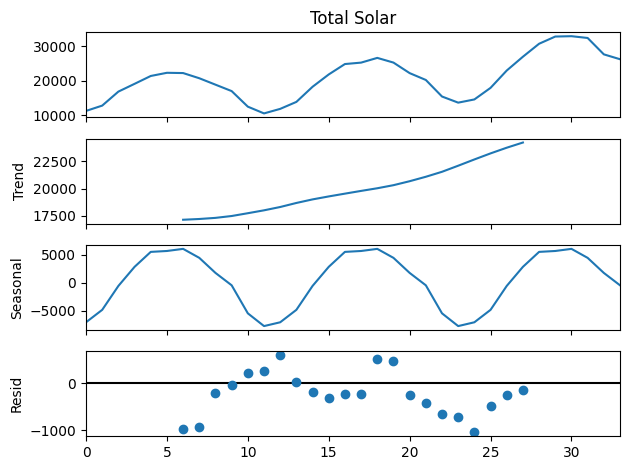

In [15]:
# Visualizing the decomposition and trend
decomposition = seasonal_decompose(total_solar, model='additive', period=12)  # Adjust period if necessary
decomposition.plot()
plt.show()

In [16]:
# Augmented Dickey-Fuller Test for stationarity
adf_test = adfuller(total_solar.dropna())
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"   {key}: {value}")

ADF Statistic: 3.2519566477447523
p-value: 1.0
Critical Values:
   1%: -3.7377092158564813
   5%: -2.9922162731481485
   10%: -2.635746736111111


#### Interpreting the ADF Test
Here we see that the p value is much greater than 0.05, which implies our data is not stationary. Thus, we have to do a differencing.

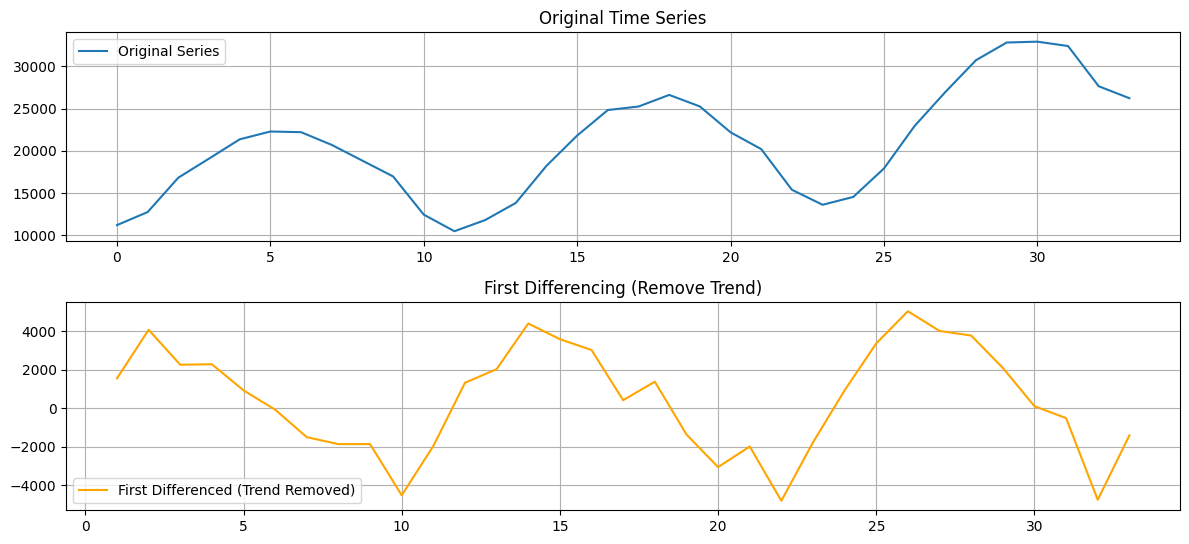

In [17]:
# First differencing to remove trend
first_difference = total_solar.diff().dropna()

# Plotting the original and differenced series
plt.figure(figsize=(12, 8))

# Original series
plt.subplot(3, 1, 1)
plt.plot(total_solar, label='Original Series')
plt.title('Original Time Series')
plt.legend()
plt.grid()

# First differencing
plt.subplot(3, 1, 2)
plt.plot(first_difference, label='First Differenced (Trend Removed)', color='orange')
plt.title('First Differencing (Remove Trend)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [18]:
adf_test = adfuller(first_difference.dropna())
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"   {key}: {value}")

ADF Statistic: -3.4136934311896043
p-value: 0.01050082735150278
Critical Values:
   1%: -3.7377092158564813
   5%: -2.9922162731481485
   10%: -2.635746736111111


#### Reading the Differencing
Here we see that through differencing once, we achieve stationary data. Thus, we can select our d parameter as 1. **d = 1**

# III. Implementing SARIMAX Forecasting

### i. Utility Scale

In [21]:
# Loading features
tsi_data = all_data.loc[monthly_data.index]
features_utility = pd.DataFrame({'TSI': tsi_data['TSI'],
                                 'Growth Factor': params_utility[1]
                                }, index = monthly_data.index)

# Verify features loading
print(features_utility.head())

           TSI  Growth Factor
0  1361.692383       0.230189
1  1361.692383       0.230189
2  1361.590088       0.230189
3  1361.590088       0.230189
4  1362.293213       0.230189


In [23]:
# Training the model
model = SARIMAX(utility_gen, exog=features_utility, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
result = model.fit(disp=False)
print(result.summary())

C:\Users\brayk\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:           Utility Scale Generation   No. Observations:                   34
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -171.266
Date:                            Mon, 20 Jan 2025   AIC                            356.532
Time:                                    12:58:32   BIC                            363.844
Sample:                                         0   HQIC                           358.119
                                             - 34                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
TSI            -352.9116    745.989     -0.473      0.636   -1815.023    1109.200
Growth Factor  2.669e-08  

In [24]:
# Number of steps to forecast
forecast_steps = 12  # Predict the next 12 months

# Ensure the index is in datetime format
monthly_data.index = pd.to_datetime(monthly_data.index)

# Create future index for the forecast period
forecast_index = pd.date_range(start=monthly_data.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


# Ensure the index of tsi_data is in datetime format
tsi_data.index = pd.to_datetime(tsi_data.index)

# Ensure forecast_index is also in datetime format (it should already be, but for consistency)
forecast_index = pd.to_datetime(forecast_index)

# Reindex TSI to match the forecast period
future_tsi = tsi_data['TSI'].reindex(forecast_index, method='ffill')  # Forward fill to handle missing data

future_growth_factor = np.full(len(forecast_index), params_utility[1])  # Use the same growth factor

# Combine future features into a DataFrame
future_features = pd.DataFrame({
    'TSI': future_tsi,
    'Growth Factor': future_growth_factor
}, index=forecast_index)

# Make predictions
forecast = result.get_forecast(steps=forecast_steps, exog=future_features)

# Extract the forecasted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

C:\Users\brayk\AppData\Local\Temp\ipykernel_3232\3940889727.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=monthly_data.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


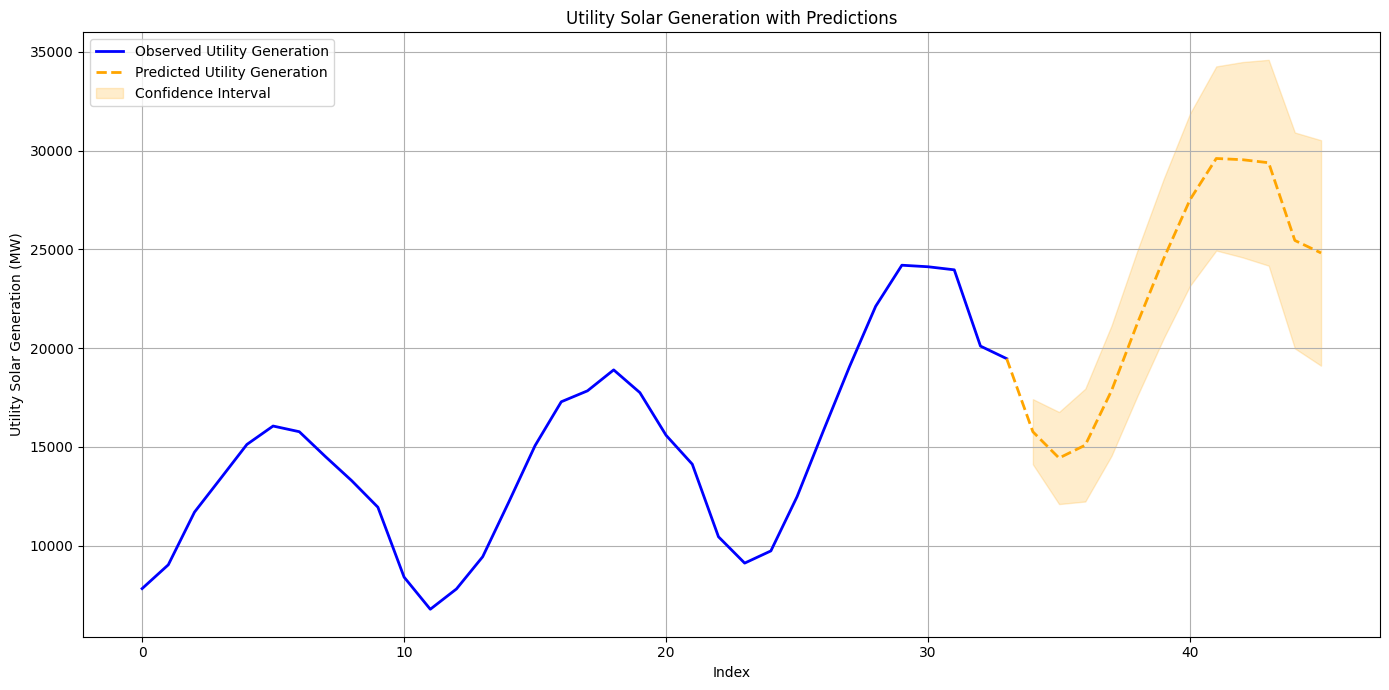

Forecasted Values:
34    15762.077276
35    14431.759764
36    15085.665444
37    17834.669003
38    21287.920174
39    24545.949580
40    27513.889697
41    29596.569395
42    29534.163888
43    29381.558138
44    25447.216434
45    24813.203714
Name: predicted_mean, dtype: float64


In [25]:
# Prepare indices for observed and forecast data
observed_indices = range(len(utility_gen))  # Indices for observed data
forecast_indices = range(len(utility_gen) - 1, len(utility_gen) + forecast_steps)  # Overlap at the transition

# Prepare forecast data with connection
forecast_values = [utility_gen.iloc[-1]] + list(forecast_mean.values)  # Start forecast with the last observed value

# Plot the observed data and predictions
plt.figure(figsize=(14, 7))
plt.plot(observed_indices, utility_gen, label='Observed Utility Generation', color='blue', linewidth=2)
plt.plot(forecast_indices, forecast_values, label='Predicted Utility Generation', color='orange', linestyle='--', linewidth=2)
plt.fill_between(
    range(len(utility_gen), len(utility_gen) + forecast_steps),  # Confidence intervals for forecast only
    forecast_conf_int.iloc[:, 0],
    forecast_conf_int.iloc[:, 1],
    color='orange', alpha=0.2, label='Confidence Interval'
)
plt.xlabel('Index')
plt.ylabel('Utility Solar Generation (MW)')
plt.title('Utility Solar Generation with Predictions')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Print forecasted values
print("Forecasted Values:")
print(forecast_mean)

### ii. Small Scale

In [30]:
tsi_data = all_data.loc[monthly_data.index]
features_small = pd.DataFrame({'TSI': tsi_data['TSI'],
                                 'Growth Factor': params_small[1]
                                }, index = monthly_data.index)
print(features_small.head())

           TSI  Growth Factor
0  1361.692383       0.205533
1  1361.692383       0.205533
2  1361.590088       0.205533
3  1361.590088       0.205533
4  1362.293213       0.205533


In [31]:
model = SARIMAX(small_scale_gen, exog=features_small, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
result = model.fit(disp=False)
print(result.summary())

C:\Users\brayk\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:             Small Scale Generation   No. Observations:                   34
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -131.824
Date:                            Mon, 20 Jan 2025   AIC                            277.648
Time:                                    13:00:25   BIC                            284.960
Sample:                                         0   HQIC                           279.235
                                             - 34                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
TSI            -177.1171    128.051     -1.383      0.167    -428.093      73.859
Growth Factor -1.669e-07  

In [32]:
# Number of steps to forecast
forecast_steps = 12  # Predict the next 12 months

# Ensure the index is in datetime format
monthly_data.index = pd.to_datetime(monthly_data.index)

# Create future index for the forecast period
forecast_index = pd.date_range(start=monthly_data.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


# Ensure the index of tsi_data is in datetime format
tsi_data.index = pd.to_datetime(tsi_data.index)

# Ensure forecast_index is also in datetime format (it should already be, but for consistency)
forecast_index = pd.to_datetime(forecast_index)

# Reindex TSI to match the forecast period
future_tsi = tsi_data['TSI'].reindex(forecast_index, method='ffill')  # Forward fill to handle missing data

future_growth_factor = np.full(len(forecast_index), params_utility[1])  # Use the same growth factor

# Combine future features into a DataFrame
future_features = pd.DataFrame({
    'TSI': future_tsi,
    'Growth Factor': future_growth_factor
}, index=forecast_index)

# Make predictions
forecast = result.get_forecast(steps=forecast_steps, exog=future_features)

# Extract the forecasted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

C:\Users\brayk\AppData\Local\Temp\ipykernel_3232\3940889727.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=monthly_data.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


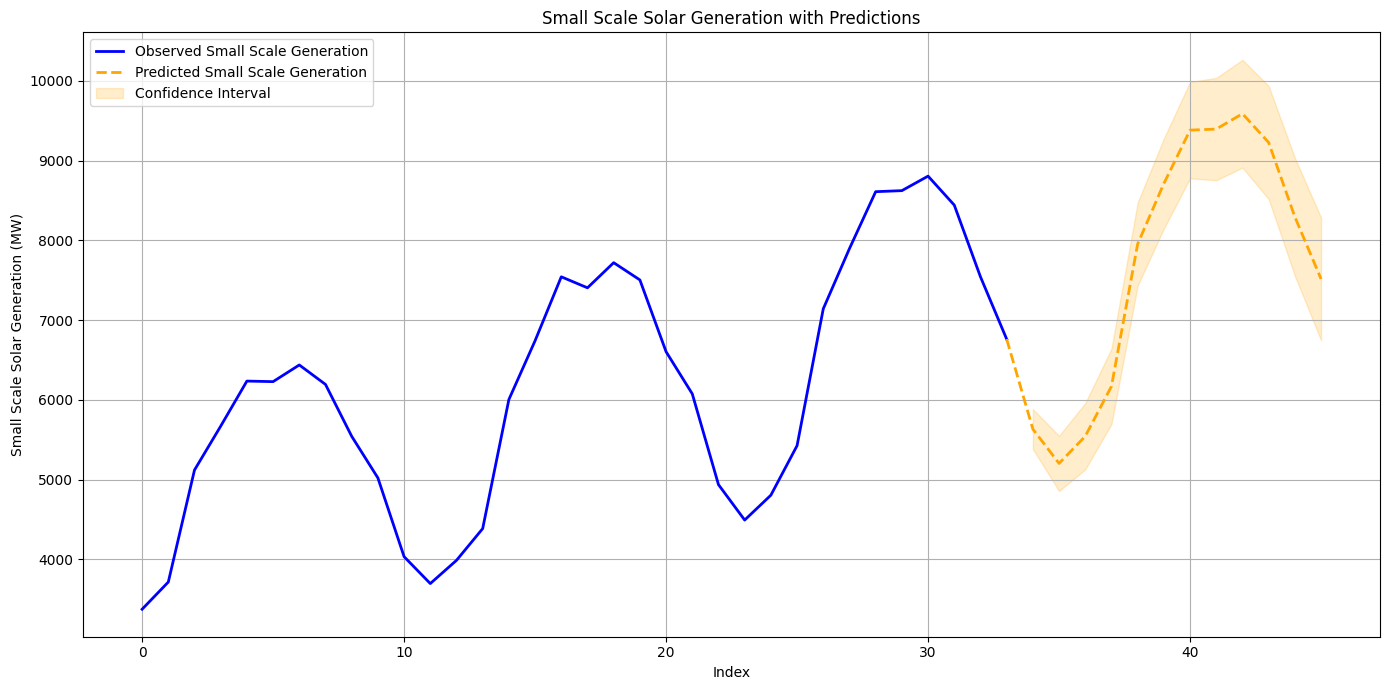

Forecasted Values:
34    5633.840247
35    5204.050081
36    5544.670627
37    6170.179029
38    7954.243788
39    8712.229468
40    9381.448950
41    9394.678278
42    9587.251007
43    9226.304068
44    8294.358324
45    7515.966796
Name: predicted_mean, dtype: float64


In [33]:
# Prepare indices for observed and forecast data
observed_indices = range(len(small_scale_gen))  # Indices for observed data
forecast_indices = range(len(small_scale_gen) - 1, len(small_scale_gen) + forecast_steps)  # Overlap at the transition

# Prepare forecast data with connection
forecast_values = [small_scale_gen.iloc[-1]] + list(forecast_mean.values)  # Start forecast with the last observed value

# Plot the observed data and predictions
plt.figure(figsize=(14, 7))
plt.plot(observed_indices, small_scale_gen, label='Observed Small Scale Generation', color='blue', linewidth=2)
plt.plot(forecast_indices, forecast_values, label='Predicted Small Scale Generation', color='orange', linestyle='--', linewidth=2)
plt.fill_between(
    range(len(small_scale_gen), len(small_scale_gen) + forecast_steps),  # Confidence intervals for forecast only
    forecast_conf_int.iloc[:, 0],
    forecast_conf_int.iloc[:, 1],
    color='orange', alpha=0.2, label='Confidence Interval'
)
plt.xlabel('Index')
plt.ylabel('Small Scale Solar Generation (MW)')
plt.title('Small Scale Solar Generation with Predictions')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Print forecasted values
print("Forecasted Values:")
print(forecast_mean)